In [1]:
# data loading
from sklearn.preprocessing import LabelEncoder
import os
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_dataset(base_dir):
    features = []
    labels = []
    for genre in os.listdir(base_dir):
        genre_dir = os.path.join(base_dir, genre)
        if not os.path.isdir(genre_dir):
            continue
        for fname in os.listdir(genre_dir):
            if fname.endswith('.pt'):
                path = os.path.join(genre_dir, fname)
                tensor = torch.load(path).flatten().numpy()
                features.append(tensor)
                labels.append(genre)
    return np.array(features), np.array(labels)

file_dir = "D:/Documents/A-APS360/Music_Genre_Classification/Documents/APS360/Project/train_set/processed_spectrograms_v2"

X_train, y_train = load_dataset(file_dir + "/train")
X_val, y_val = load_dataset(file_dir + "/val")

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

def get_data_loader(
    target_classes,
    batch_size=64,
    root_dir="D:/Documents/A-APS360/Music_Genre_Classification/Documents/APS360/Project/train_set/processed_spectrograms_v2",
    random_seed=1000
):
    """
    Adapted for music genre classification using pre-processed .pt files

    Args:
        target_classes: List of genre classes to include (or None for all)
        batch_size: samples per batch
        root_dir: path to directory containing train/val/test folders
        random_seed: for reproducible results

    Returns:
        train_loader, val_loader, test_loader, classes
    """

    # Set random seed for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # Load all datasets using existing function
    X_train, y_train = load_dataset(root_dir + "/train")
    X_val, y_val = load_dataset(root_dir + "/val")

    # Encode labels using existing label encoder
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train_encoded)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val_encoded)


    # Reshape to 128x128 images (inputs are confirmed to be this size)
    X_train_tensor = X_train_tensor.view(-1, 1, 128, 128)
    X_val_tensor = X_val_tensor.view(-1, 1, 128, 128)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Get class names from label encoder
    classes = le.classes_.tolist()

    # Filter by target_classes if specified
    if target_classes is not None:
        # This would require more complex filtering logic
        # For now, we'll just return all classes
        pass

    print(f"Loaded {len(train_dataset)} training, {len(val_dataset)} validation")
    print(f"Classes: {classes}")

    return train_loader, val_loader, classes

In [3]:
def evaluate_multiclass(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_err = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            total_err += (preds != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

    avg_err = total_err / total_samples
    avg_loss = total_loss / len(dataloader)
    return avg_err, avg_loss

from sklearn.metrics import classification_report

def evaluate_per_class(model, dataloader, le, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    report = classification_report(all_labels, all_preds, target_names=le.classes_, zero_division=0)
    print(f"/nTest Set Classification Report (Avg Loss: {avg_loss:.4f}):/n")
    print(report)

def get_model_name(name, batch_size, learning_rate, epoch, base_dir="models"):
    # Create base directory if it doesn't exist
    os.makedirs(base_dir, exist_ok=True)

    # Format model path
    path = os.path.join(base_dir, "model_{0}_bs{1}_lr{2}_epoch{3}.pt".format(
        name, batch_size, learning_rate, epoch))

    return path

Meefo Stuff

In [4]:
#stuff for model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

# normalize data (penalizing weights so to speak)
from sklearn.utils.class_weight import compute_class_weight

# activation function
import numpy as np
from scipy.special import erf

#(dont use this for now; guarantee values w/ reLU first)
def activation(x):
  return -x * erf(np.exp(-x))

# pooling
def pool(dim, kernel, stride = 1, padding = 0):
  out = ((dim + 2*padding - kernel) // stride ) + 1
  return out

# model
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k, p=None, s=1, groups=1):
        super().__init__()
        if isinstance(k, int):
            k = (k, k)
        if p is None:
            p = (k[0] // 2, k[1] // 2)
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, groups=groups, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class DSConv(nn.Module):
    """Depthwise-separable conv: depthwise 3x3 + pointwise 1x1."""
    def __init__(self, in_ch, out_ch, k=(3,3)):
        super().__init__()
        p = (k[0]//2, k[1]//2)
        self.dw = ConvBNReLU(in_ch, in_ch, k=k, p=p, groups=in_ch)
        self.pw = ConvBNReLU(in_ch, out_ch, k=1, p=0)
    def forward(self, x):
        return self.pw(self.dw(x))

# ---------- the model ----------

# IMPROVED GLIZZYNET V2 ARCHITECTURE
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- small building blocks ----------

class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k, p=None, s=1, groups=1):
        super().__init__()
        if isinstance(k, int):
            k = (k, k)
        if p is None:
            p = (k[0] // 2, k[1] // 2)
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, groups=groups, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class DSConv(nn.Module):
    """Depthwise-separable conv: depthwise 3x3 + pointwise 1x1."""
    def __init__(self, in_ch, out_ch, k=(3,3)):
        super().__init__()
        p = (k[0]//2, k[1]//2)
        self.dw = ConvBNReLU(in_ch, in_ch, k=k, p=p, groups=in_ch)
        self.pw = ConvBNReLU(in_ch, out_ch, k=1, p=0)
    def forward(self, x):
        return self.pw(self.dw(x))

# ---------- the model ----------

class GlizzyNetV2(nn.Module):
    """
    Input: mel-spectrograms shaped (B, 1, Freq, Time), normalized (e.g., log-mel, mean/std per-dataset).
    """
    def __init__(self, num_classes: int, dropout: float = 0.2):
        super().__init__()
        self.name = "GlizzyNetV2"

        # Feature extractor — early layers see wider time context
        self.feat = nn.Sequential(
            # Block 1: time-aware receptive field
            ConvBNReLU(1,   32, k=(3,7)),    # (3x7) captures short-time patterns
            nn.MaxPool2d((2,2)),
            nn.Dropout2d(p=dropout*0.5),

            # Block 2: still a bit wider in time
            ConvBNReLU(32,  64, k=(3,5)),
            nn.MaxPool2d((2,2)),
            nn.Dropout2d(p=dropout*0.5),

            # Block 3: depthwise-separable for efficiency
            DSConv(64, 128, k=(3,3)),
            nn.MaxPool2d((2,2)),
            nn.Dropout2d(p=dropout),

            # Block 4: another DS block; keep channels modest
            DSConv(128, 192, k=(3,3)),
            nn.MaxPool2d((2,2)),
            nn.Dropout2d(p=dropout),
        )

        # Global pooling makes it robust to varying input sizes
        self.pool = nn.AdaptiveAvgPool2d((1,1))  # -> (B, C, 1, 1)

        # Compact classifier
        self.cls = nn.Sequential(
            nn.Flatten(),             # -> (B, 192)
            nn.Linear(192, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feat(x)
        x = self.pool(x)
        x = self.cls(x)
        return x

print("GlizzyNetV2 architecture added!")
print("\nKey improvements over original GlizzyNet:")
print("1. Time-aware convolutions: (3×7) and (3×5) kernels capture temporal patterns better")
print("2. Depthwise-separable convolutions: More efficient, fewer parameters")
print("3. Proper weight initialization: Kaiming normal for ReLU networks")
print("4. Fewer channels overall: 192 vs 512, reduces overfitting")
print("5. Compact classifier: Only 192→128→classes vs 512→235→classes")
    
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30, target_classes=None, y_train=None):
    ########################################################################
    # Train a classifier on music genres
    if target_classes is None:
        raise ValueError("target_classes must be specified for music genre classification")

    torch.manual_seed(1000)

    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, classes = get_data_loader(target_classes, batch_size)

    ########################################################################
    # Define the Loss function and optimizer

    # Use weighted loss
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    # optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    ########################################################################
    # Set up arrays to store training/validation metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    ########################################################################
    # Train the network
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)  # shape: [batch_size, num_classes]
            loss = criterion(outputs, labels)  # labels are class indices [0, ..., C-1]
            loss.backward()
            optimizer.step()

            # Compute number of incorrect predictions
            preds = torch.argmax(outputs, dim=1)
            total_train_err += (preds != labels).sum().item()
            total_train_loss += loss.item()
            total_samples += labels.size(0)

        train_err[epoch] = total_train_err / total_samples
        train_loss[epoch] = total_train_loss / (i + 1)

        # Evaluate on validation set
        val_err[epoch], val_loss[epoch] = evaluate_multiclass(net, val_loader, criterion)

        print(f"Epoch {epoch+1}: "
              f"Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Val err: {val_err[epoch]:.4f}, Val loss: {val_loss[epoch]:.4f}")

        # Save checkpoint
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    print(f"Total time elapsed: {time.time() - start_time:.2f} seconds")

    # Save logs for plotting
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)

    # Save final model
    final_model_path = get_model_name(net.name, batch_size, learning_rate, 'final')
    torch.save(net.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")

GlizzyNetV2 architecture added!

Key improvements over original GlizzyNet:
1. Time-aware convolutions: (3×7) and (3×5) kernels capture temporal patterns better
2. Depthwise-separable convolutions: More efficient, fewer parameters
3. Proper weight initialization: Kaiming normal for ReLU networks
4. Fewer channels overall: 192 vs 512, reduces overfitting
5. Compact classifier: Only 192→128→classes vs 512→235→classes


In [5]:
# Training Curve (borrowed from lab 2)
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Train vs Validation Error")
    n = len(train_err)
    plt.plot(range(1, n+1), train_err, label="Train")
    plt.plot(range(1, n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, n+1), train_loss, label="Train")
    plt.plot(range(1, n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Meefo Stuff

In [6]:
'''
import csv
import gc

# Define the hyperparameter search space
search_space = {
    'lr': (1e-5, 1e-2),
    'dropout': (0.1, 0.5),
    'hidden_size': (32, 256),
    'batch_size': (32, 128)
}

# Define the fitness function to be minimized (validation error)
def fitness_function(params):
    import torch.nn as nn
    from torch import optim
    from sklearn.utils.class_weight import compute_class_weight

    lr = params['lr']
    dropout = params['dropout']
    hidden_size = int(params['hidden_size'])
    batch_size = int(params['batch_size'])

    model = GlizzyNet(num_classes=12, dropout=dropout, hidden_size=hidden_size).to(device)
    train_loader, val_loader, _ = get_data_loader(target_classes, batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model_path = get_model_name(model.name, batch_size, lr, np.random.randint(10000))
    num_epochs = 50  # keep low for MEEFO speed

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train()
        total_err, total_loss, total_samples = 0, 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, dim=1)
            total_err += (preds != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

        train_err[epoch] = total_err / total_samples
        train_loss[epoch] = total_loss / len(train_loader)

        # Evaluate validation set each epoch
        val_err[epoch], val_loss[epoch] = evaluate_multiclass(model, val_loader, criterion)

    # Save all logs
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)


    # Plot training curve for this iteration
    plot_training_curve(model_path)

    # Save model weights
    save_dir = "D:/Documents/A-APS360/Music_Genre_Classification/Documents/APS360/Project/meefo_checkpoints/"
    os.makedirs(save_dir, exist_ok=True)

    checkpoint_name = f"chkpt_dropout{dropout:.3f}_hid{hidden_size}_bs{batch_size}_lr{lr:.6f}.pt"
    torch.save(model.state_dict(), os.path.join(save_dir, checkpoint_name))

    log_path = "D:/Documents/A-APS360/Music_Genre_Classification/Documents/APS360/Project/meefo_checkpoints/results_log.csv"
    with open(log_path, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([checkpoint_name, float(val_err[-1])])


    del model, inputs, labels, outputs, preds, loss, optimizer
    del train_loader, val_loader, train_err, train_loss, val_loss

    torch.cuda.empty_cache()
    gc.collect()

    return np.mean(val_err)
    '''


'\nimport csv\nimport gc\n\n# Define the hyperparameter search space\nsearch_space = {\n    \'lr\': (1e-5, 1e-2),\n    \'dropout\': (0.1, 0.5),\n    \'hidden_size\': (32, 256),\n    \'batch_size\': (32, 128)\n}\n\n# Define the fitness function to be minimized (validation error)\ndef fitness_function(params):\n    import torch.nn as nn\n    from torch import optim\n    from sklearn.utils.class_weight import compute_class_weight\n\n    lr = params[\'lr\']\n    dropout = params[\'dropout\']\n    hidden_size = int(params[\'hidden_size\'])\n    batch_size = int(params[\'batch_size\'])\n\n    model = GlizzyNet(num_classes=12, dropout=dropout, hidden_size=hidden_size).to(device)\n    train_loader, val_loader, _ = get_data_loader(target_classes, batch_size)\n\n    criterion = nn.CrossEntropyLoss()\n    optimizer = optim.Adam(model.parameters(), lr=lr)\n\n    model_path = get_model_name(model.name, batch_size, lr, np.random.randint(10000))\n    num_epochs = 50  # keep low for MEEFO speed\n\n   

In [7]:
'''
import numpy as np
import random
import pickle
import os

def run_meefo_optimization(fitness_fn, search_space, pop_size=10, max_iter=20):
    state_dir = "D:/Documents/A-APS360/Music_Genre_Classification/Documents/APS360/Project/meefo_state"
    state_path = os.path.join(state_dir, "meefo_state.pkl")
    resume = os.path.exists(state_path)
    

    def initialize_population():
        population = []
        for _ in range(pop_size):
            individual = {}
            for key, (low, high) in search_space.items():
                value = np.random.uniform(low, high)
                # Force integer for specific keys
                if key in ['batch_size', 'hidden_size']:
                    value = int(np.round(value))
                individual[key] = value
            population.append(individual)
        return population


    def clip_params(params):
        return {key: np.clip(val, *search_space[key]) for key, val in params.items()}

    def evaluate_population(pop):
        scores = []
        for i, ind in enumerate(pop):
            try:
                score = fitness_fn(ind)

                # Enforce scalar float from any shape
                if isinstance(score, (np.ndarray, list)):
                    score = np.ravel(score)  # flatten to 1D
                    if len(score) != 1:
                        raise ValueError(f"Fitness function returned array of shape {score.shape}")
                    score = float(score[0])

                if score is None or not np.isfinite(score):
                    raise ValueError("Invalid score (None, NaN, or Inf)")

                scores.append(score)

            except Exception as e:
                print(f"[Warning] Individual {i} failed: {e}")
                scores.append(np.inf)  # Penalize failure

        return scores

    if os.path.exists(state_path):
        with open(state_path, "rb") as f:
            saved = pickle.load(f)
        population = saved["population"]
        scores = saved["scores"]
        best_sol = saved["best_sol"]
        start_iter = saved["iteration"]
        resume = True
    else:
        population = initialize_population()
        scores = evaluate_population(population)
        best_idx = int(np.argmin(scores))
        best_sol = population[best_idx]
        start_iter = 0

        # Immediately create the state file
        os.makedirs(os.path.dirname(state_path), exist_ok=True)
        with open(state_path, "wb") as f:
            pickle.dump({
                "population": population,
                "scores": scores,
                "best_sol": best_sol,
                "iteration": start_iter
            }, f)
        print(f"[MEEFO INIT] State initialized and saved to {state_path}")


    for t in range(start_iter, max_iter):
        new_population = []
        for i in range(pop_size):
            ind = population[i]
            partner = population[random.randint(0, pop_size - 1)]
            child = {}
            for k in search_space:
                alpha = np.random.rand()
                child[k] = alpha * ind[k] + (1 - alpha) * partner[k]
            child = clip_params(child)
            new_population.append(child)

        new_scores = evaluate_population(new_population)
        for i in range(pop_size):
            if new_scores[i] < scores[i]:
                population[i] = new_population[i]
                scores[i] = new_scores[i]

        best_idx = int(np.argmin(scores))
        best_sol = population[best_idx]
        print(f"[MEEFO iter {t+1}] Best val error: {scores[best_idx]:.4f}")

        state_dir = "D:/Documents/A-APS360/Music_Genre_Classification/Documents/APS360/Project/meefo_state"
        state_path = os.path.join(state_dir, "meefo_state.pkl")

        with open(state_path, "wb") as f:
            pickle.dump({
                "population": population,
                "scores": scores,
                "best_sol": best_sol,
                "iteration": t + 1
            }, f)

    return best_sol
    '''

'\nimport numpy as np\nimport random\nimport pickle\nimport os\n\ndef run_meefo_optimization(fitness_fn, search_space, pop_size=10, max_iter=20):\n    state_dir = "D:/Documents/A-APS360/Music_Genre_Classification/Documents/APS360/Project/meefo_state"\n    state_path = os.path.join(state_dir, "meefo_state.pkl")\n    resume = os.path.exists(state_path)\n\n\n    def initialize_population():\n        population = []\n        for _ in range(pop_size):\n            individual = {}\n            for key, (low, high) in search_space.items():\n                value = np.random.uniform(low, high)\n                # Force integer for specific keys\n                if key in [\'batch_size\', \'hidden_size\']:\n                    value = int(np.round(value))\n                individual[key] = value\n            population.append(individual)\n        return population\n\n\n    def clip_params(params):\n        return {key: np.clip(val, *search_space[key]) for key, val in params.items()}\n\n    def e

In [8]:
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.current_device())  # Should return 0
print(torch.cuda.get_device_name(0))  # Should return something like RTX 3060
print(torch.cuda.memory_allocated())  # Should be >0 during training
print(torch.cuda.memory_reserved())  # Also should be >0

True
0
NVIDIA GeForce RTX 3060
0
0


Loaded 3503 training, 1206 validation
Classes: ['Classical', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time . Historic', 'Pop', 'Rock', 'Spoken']
Epoch 1: Train err: 0.9172, Train loss: 2.7424 | Val err: 0.8939, Val loss: 2.4830
Epoch 1: Train err: 0.9172, Train loss: 2.7424 | Val err: 0.8939, Val loss: 2.4830
Epoch 2: Train err: 0.9129, Train loss: 2.5192 | Val err: 0.9146, Val loss: 2.4835
Epoch 2: Train err: 0.9129, Train loss: 2.5192 | Val err: 0.9146, Val loss: 2.4835
Epoch 3: Train err: 0.9118, Train loss: 2.4951 | Val err: 0.8964, Val loss: 2.4836
Epoch 3: Train err: 0.9118, Train loss: 2.4951 | Val err: 0.8964, Val loss: 2.4836
Epoch 4: Train err: 0.9181, Train loss: 2.4909 | Val err: 0.9303, Val loss: 2.4846
Epoch 4: Train err: 0.9181, Train loss: 2.4909 | Val err: 0.9303, Val loss: 2.4846
Epoch 5: Train err: 0.9132, Train loss: 2.4900 | Val err: 0.9022, Val loss: 2.4847
Epoch 5: Train err: 0.9132, Train loss: 2.4900 | Val e

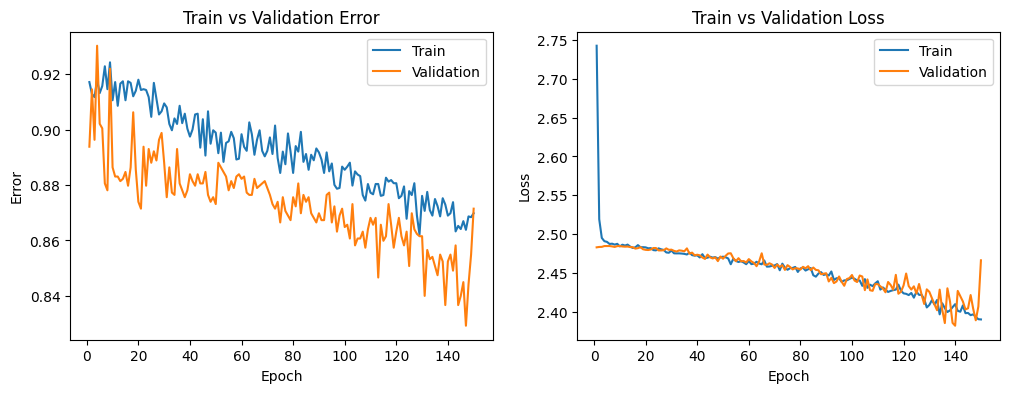

In [9]:
target_classes = le.classes_.tolist()

'''
# Run MEEFO
best_params = run_meefo_optimization(fitness_function, search_space, pop_size=10, max_iter=20)

print("/nBest Hyperparameters from MEEFO:")
print(best_params)
'''

# Final training run with best parameters
best_params = best_params = {
    'lr': 0.001,            # Learning rate: A common starting point for Adam optimizer
    'dropout': 0.3,         # Dropout: Moderate regularization to prevent overfitting
    'hidden_size': 128,     # Hidden size: Matches the compact classifier's intermediate layer
    'batch_size': 64        # Batch size: Balanced for training speed and memory usage
}
net = GlizzyNetV2(num_classes=12, dropout=best_params['dropout'])
net = net.to(device)
train_net(
    net,
    batch_size=int(best_params['batch_size']),
    learning_rate=best_params['lr'],
    num_epochs=150,
    target_classes=target_classes,
    y_train=y_train
)

final_model_path = get_model_name(net.name, int(best_params['batch_size']), best_params['lr'], 149)
plot_training_curve(final_model_path)



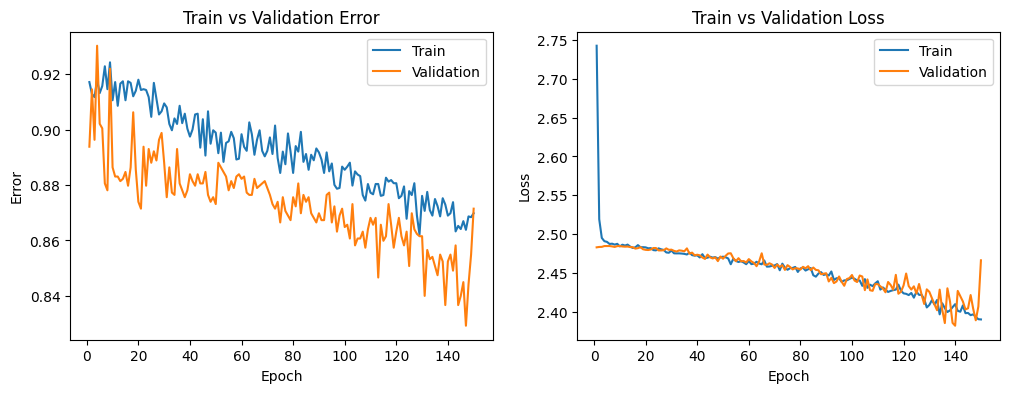

In [10]:
final_model_path = get_model_name(net.name, int(best_params['batch_size']), best_params['lr'], 149)
plot_training_curve(final_model_path)

torch.save(net.state_dict(), final_model_path)

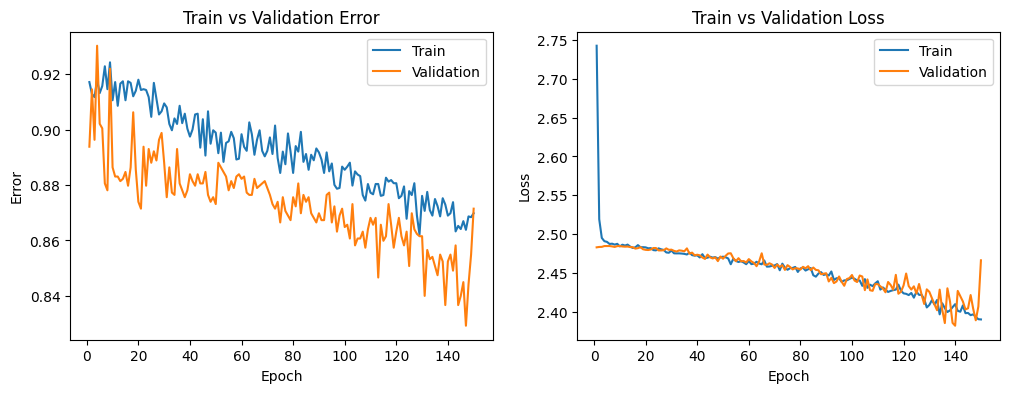

Loaded 1132 test samples
Classes in test set: ['Classical', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time . Historic', 'Pop', 'Rock', 'Spoken']
/nTest Set Classification Report (Avg Loss: 2.5350):/n
                     precision    recall  f1-score   support

          Classical       0.00      0.00      0.00       100
         Electronic       0.05      0.01      0.02       100
       Experimental       0.06      0.15      0.09        99
               Folk       0.05      0.01      0.02        99
            Hip-Hop       0.11      0.24      0.15       100
       Instrumental       0.00      0.00      0.00       100
      International       0.10      0.03      0.05       100
               Jazz       0.21      0.05      0.08        99
Old-Time . Historic       0.13      0.20      0.16       100
                Pop       0.34      0.18      0.24       100
               Rock       0.05      0.12      0.07       100
             S

In [11]:
# work on test set
def load_test_data(test_dir, le, batch_size=64):
    """
    Load test data using the existing LabelEncoder
    
    Args:
        test_dir: Path to directory containing test data
        le: Existing LabelEncoder instance
        batch_size: samples per batch
    
    Returns:
        test_loader: DataLoader for test set
        classes: List of class names
    """
    # Load test data
    X_test, y_test = load_dataset(test_dir)
    
    # Encode labels using existing label encoder
    y_test_encoded = le.transform(y_test)  # Use transform() not fit_transform()
    
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test_encoded)
    
    # Reshape to 224x224 images
    X_test_tensor = X_test_tensor.view(-1, 1, 128, 128)
    
    # Create TensorDataset and DataLoader
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Loaded {len(test_dataset)} test samples")
    print(f"Classes in test set: {le.classes_.tolist()}")
    
    return test_loader

plot_training_curve(final_model_path)

test_dir = "D:\\Documents\\A-APS360\\Music_Genre_Classification\\Documents\\APS360\\Project\\test-set-random\\test set random\\test_updated"
test_loader = load_test_data(test_dir, le, 64)

# Use weighted loss
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

evaluate_per_class(net, test_loader, le, criterion)